<a href="https://colab.research.google.com/github/GrainSack/ML/blob/main/Louvian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import networkx as nx
import os
import random as random
import pandas as pd
import time as time
import matplotlib as plt
import networkx.algorithms.community as nx_comm
from collections import defaultdict, deque
import networkx as nx
from networkx.algorithms.community import modularity
from networkx.utils import py_random_state
from matplotlib import pyplot

In [3]:
os.getcwd()

'/content'

In [4]:
data = pd.read_csv('football.csv', delimiter=' ')

In [5]:
data = data.reset_index()

In [6]:
data.head()

,index,Edge
0,2,1
1,2,26
2,2,28
3,2,34
4,2,38


In [7]:
edge_list = []

for i in range(len(data)):
  x =data['index'][i]
  y = data['Edge'][i]
  edge_list.append([x,y])

In [8]:
edge_list[:5]

[[2, 1], [2, 26], [2, 28], [2, 34], [2, 38]]

In [170]:
G = nx.MultiGraph()

In [171]:
for idx in range(len(edge_list)):
  G.add_edge(edge_list[idx][0],edge_list[idx][1])

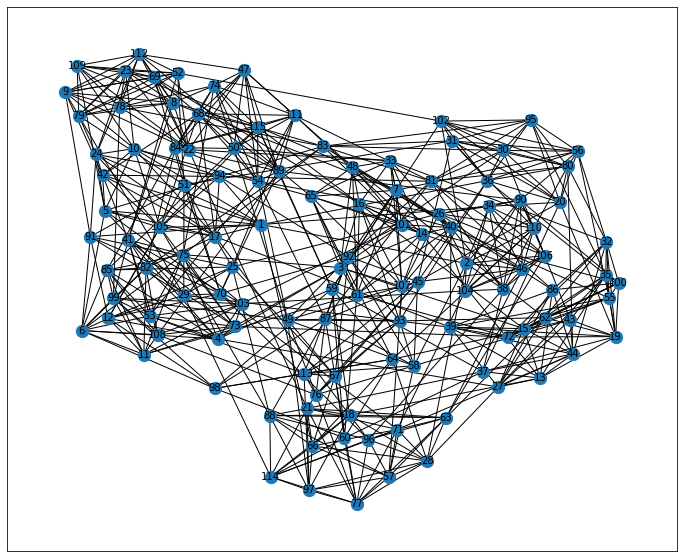

In [172]:
nx.draw_networkx(G, pos=None, arrows=None, with_labels=True,node_size = 150,font_size = 10,  cmap = 'Matplotlib colormap')

In [30]:
def _neighbor_weights(nbrs, node2com):
    """Calculate weights between node and its neighbor communities."""
    weights = defaultdict(float)
    for nbr, wt in nbrs.items():
        weights[node2com[nbr]] += wt
    return weights

def _gen_graph(G, partition):
    """Generate a new graph based on the partitions of a given graph"""
    H = G.__class__()
    node2com = {}
    for i, part in enumerate(partition):
        nodes = set()
        for node in part:
            node2com[node] = i
            nodes.update(G.nodes[node].get("nodes", {node}))
        H.add_node(i, nodes=nodes)

    for node1, node2, wt in G.edges(data=True):
        wt = wt["weight"]
        com1 = node2com[node1]
        com2 = node2com[node2]
        temp = H.get_edge_data(com1, com2, {"weight": 0})["weight"]
        H.add_edge(com1, com2, **{"weight": wt + temp})
    return H


def _convert_multigraph(G, weight, is_directed):
    """Convert a Multigraph to normal Graph"""
    if is_directed:
        H = nx.DiGraph()
    else:
        H = nx.Graph()
    H.add_nodes_from(G)
    for u, v, wt in G.edges(data=weight, default=1):
        if H.has_edge(u, v):
            H[u][v]["weight"] += wt
        else:
            H.add_edge(u, v, weight=wt)
    return H

In [138]:
def _one_level(G, m, partition, resolution=1, is_directed=False, seed=None):
    node2com = {u: i for i, u in enumerate(G.nodes())}
    inner_partition = [{u} for u in G.nodes()]
    if is_directed:
        in_degrees = dict(G.in_degree(weight="weight"))
        out_degrees = dict(G.out_degree(weight="weight"))
        Stot_in = [deg for deg in in_degrees.values()]
        Stot_out = [deg for deg in out_degrees.values()]
        # Calculate weights for both in and out neighbours
        nbrs = {}
        for u in G:
            nbrs[u] = defaultdict(float)
            for _, n, wt in G.out_edges(u, data="weight"):
                nbrs[u][n] += wt
            for n, _, wt in G.in_edges(u, data="weight"):
                nbrs[u][n] += wt
    else:
        degrees = dict(G.degree(weight="weight"))
        Stot = [deg for deg in degrees.values()]
        nbrs = {u: {v: data["weight"] for v, data in G[u].items() if v != u} for u in G}
    rand_nodes = list(G.nodes)
    seed.shuffle(rand_nodes)
    nb_moves = 1
    improvement = False
    while nb_moves > 0:
        nb_moves = 0
        for u in rand_nodes:
            best_mod = 0
            best_com = node2com[u]
            weights2com = _neighbor_weights(nbrs[u], node2com)
            if is_directed:
                in_degree = in_degrees[u]
                out_degree = out_degrees[u]
                Stot_in[best_com] -= in_degree
                Stot_out[best_com] -= out_degree
                remove_cost = (
                    -weights2com[best_com] / m
                    + resolution
                    * (out_degree * Stot_in[best_com] + in_degree * Stot_out[best_com])
                    / m**2
                )
            else:
                degree = degrees[u]
                Stot[best_com] -= degree
                remove_cost = -weights2com[best_com] / m + resolution * (
                    Stot[best_com] * degree
                ) / (2 * m**2)
            for nbr_com, wt in weights2com.items():
                if is_directed:
                    gain = (
                        remove_cost
                        + wt / m
                        - resolution
                        * (
                            out_degree * Stot_in[nbr_com]
                            + in_degree * Stot_out[nbr_com]
                        )
                        / m**2
                    )
                else:
                    gain = (
                        remove_cost
                        + wt / m
                        - resolution * (Stot[nbr_com] * degree) / (2 * m**2)
                    )
                if gain > best_mod:
                    best_mod = gain
                    best_com = nbr_com
            if is_directed:
                Stot_in[best_com] += in_degree
                Stot_out[best_com] += out_degree
            else:
                Stot[best_com] += degree
            if best_com != node2com[u]:
                com = G.nodes[u].get("nodes", {u})
                partition[node2com[u]].difference_update(com)
                inner_partition[node2com[u]].remove(u)
                partition[best_com].update(com)
                inner_partition[best_com].add(u)
                improvement = True
                nb_moves += 1
                node2com[u] = best_com
    partition = list(filter(len, partition))
    inner_partition = list(filter(len, inner_partition))
    return partition, inner_partition, improvement

In [240]:
@py_random_state("seed")
def louvain_partitions(
    G, weight="weight", resolution=1, threshold=0.00000001, seed=None
):
    partition = [{u} for u in G.nodes()]
    mod = modularity(G, partition, resolution=resolution, weight=weight)
    is_directed = G.is_directed()
    if G.is_multigraph():
        graph = _convert_multigraph(G, weight, is_directed)
    else:
        graph = G.__class__()
        graph.add_nodes_from(G)
        graph.add_weighted_edges_from(G.edges(data=weight, default=1))

    m = graph.size(weight="weight")
    partition, inner_partition, improvement = _one_level(
        graph, m, partition, resolution, is_directed, seed
    )
    improvement = True
    while improvement:
        yield [s.copy() for s in partition]
        new_mod = modularity(
            graph, inner_partition, resolution=resolution, weight="weight"
        )
        mod_per_iter.append(new_mod)
        if new_mod - mod <= threshold:
            return
        print(mod_per_iter , abs(new_mod - mod))
        mod = new_mod
        graph = _gen_graph(graph, inner_partition)
        partition, inner_partition, improvement = _one_level(
            graph, m, partition, resolution, is_directed, seed
        )

In [241]:
@py_random_state("seed")
def louvain_communities(
    G, weight="weight", resolution=1, threshold=0.0000001, seed=None
):
    d = louvain_partitions(G, weight, resolution, threshold, seed)
    q = deque(d, maxlen=1)
    return q.pop()

In [242]:
mod_per_iter = []

In [243]:
communities = louvain_communities(G, seed=123)

[0.5749702609848072] 0.5837256399543337
[0.5749702609848072, 0.5967136724956024] 0.021743411510795174


In [52]:
pos = nx.spring_layout(G, k=0.2)

In [46]:
subnet1 = G.subgraph(communities[0])
subnet2 = G.subgraph(communities[1])
subnet3 = G.subgraph(communities[2])
subnet4 = G.subgraph(communities[3])
subnet5 = G.subgraph(communities[4])
subnet6 = G.subgraph(communities[5])
subnet7 = G.subgraph(communities[6])
subnet8 = G.subgraph(communities[7])
subnet9 = G.subgraph(communities[8])

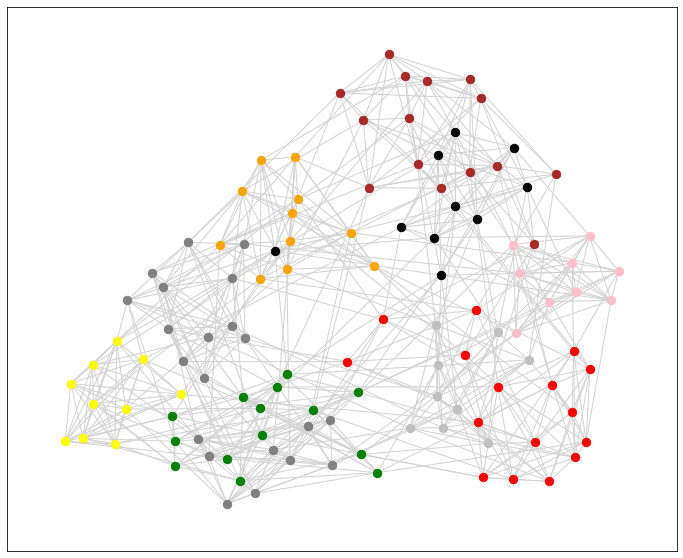

In [58]:
pyplot.rcParams['figure.figsize'] = (12, 10)  


nx.draw_networkx_nodes(subnet1, pos=pos, node_size=70, node_color='pink') 
nx.draw_networkx_nodes(subnet2, pos=pos, node_size=70, node_color='red') 
nx.draw_networkx_nodes(subnet3, pos=pos, node_size=70, node_color='grey') 
nx.draw_networkx_nodes(subnet4, pos=pos, node_size=70, node_color='black') 
nx.draw_networkx_nodes(subnet5, pos=pos, node_size=70, node_color='green') 
nx.draw_networkx_nodes(subnet6, pos=pos, node_size=70, node_color='yellow') 
nx.draw_networkx_nodes(subnet7, pos=pos, node_size=70, node_color='orange') 
nx.draw_networkx_nodes(subnet8, pos=pos, node_size=70, node_color='silver') 
nx.draw_networkx_nodes(subnet9, pos=pos, node_size=70, node_color='brown') 

nx.draw_networkx_edges(G, pos=pos, edge_color='lightgrey')

In [120]:
""" Network 생성 """
t = 10
community_number = 12
for i in range(community_number):
    globals()['Community'+str(i+1)] = range(i*t , (i+1)*t)

Community12 = range(90 , 114)

Community_all = Community1, Community2, Community3, Community4, Community5, Community6, Community7, Community8, Community9, Community10, Community11, Community12

pos = nx.spring_layout(G)

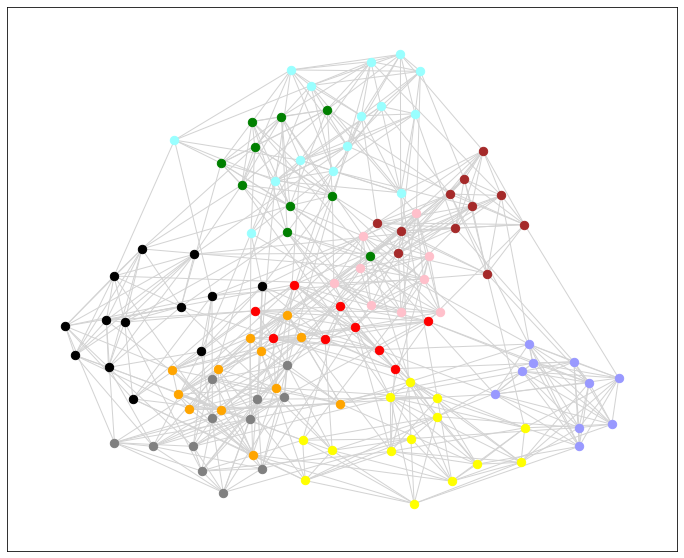

In [133]:
import community.community_louvain


""" Louvain method """
partition = community.community_louvain.best_partition(graph=G, partition=None, resolution=1., randomize=True)
max_k_w = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys()
                  if partition[nodes] == com]
    max_k_w = max_k_w + [list_nodes]

""" Make Community Color list """

community_num_group = len(max_k_w)
color_list_community = [[] for i in range(len(G.nodes()))]
for i in range(len(G.nodes())):
    for j in range(community_num_group):
        if i in max_k_w[j]:
            color_list_community[i] = j

""" Plot Community """

for i in range(len(max_k_w)):
    globals()['subnet'+str(i+1)] = G.subgraph(max_k_w[i])

nx.draw_networkx_nodes(subnet1, pos=pos, node_size=70, node_color='pink') 
nx.draw_networkx_nodes(subnet2, pos=pos, node_size=70, node_color='red') 
nx.draw_networkx_nodes(subnet3, pos=pos, node_size=70, node_color='gray') 
nx.draw_networkx_nodes(subnet4, pos=pos, node_size=70, node_color='black') 
nx.draw_networkx_nodes(subnet5, pos=pos, node_size=70, node_color='green') 
nx.draw_networkx_nodes(subnet6, pos=pos, node_size=70, node_color='yellow') 
nx.draw_networkx_nodes(subnet7, pos=pos, node_size=70, node_color='orange') 
nx.draw_networkx_nodes(subnet8, pos=pos, node_size=70, node_color='#9999FF') 
nx.draw_networkx_nodes(subnet9, pos=pos, node_size=70, node_color='brown') 
nx.draw_networkx_nodes(subnet10, pos=pos, node_size=70, node_color='#99FFFF') 

nx.draw_networkx_edges(G, pos=pos, edge_color='lightgrey')

In [132]:
max_k_w

[[2, 26, 34, 38, 46, 90, 104, 106, 110],
 [1, 5, 10, 17, 24, 42, 94, 105, 68, 115, 54, 89, 111, 47, 74, 84, 50],
 [28, 66, 18, 21, 57, 64, 71, 88, 97, 114, 63, 77, 96, 59, 60, 98],
 [58, 45, 93, 67, 92, 49, 76, 87, 113],
 [102, 36, 20, 30, 31, 56, 80, 95, 81, 83],
 [91, 29, 70, 12, 25, 51],
 [6, 82, 41, 73, 103, 4, 53, 75, 85, 11, 108, 99],
 [109, 9, 23, 79, 112, 52, 8, 69, 22, 78],
 [65, 107, 14, 3, 7, 16, 48, 61, 101, 33, 40],
 [39, 35, 27, 37, 43, 100, 15, 86, 13, 44, 55, 72, 62, 32, 19]]